In [76]:
###################################################################################################################
import numpy as np
import h5py
import torch
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from numpy import inf
from numpy import array
from numpy import argmax
import pickle
import argparse, sys, os
import time
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch
from torch.autograd import Variable
import torchvision.transforms.functional as Fv
from torch.optim import lr_scheduler
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torchvision import datasets, transforms


from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
with open('ix_tr_2.pickle', 'rb') as f:
    ix_tr = pickle.load(f)
with open('ix_vl_2.pickle', 'rb') as f:
    ix_vl = pickle.load(f)
with open('ix_ts_2.pickle', 'rb') as f:
    ix_ts = pickle.load(f)
with open('iy_tr_2.pickle', 'rb') as f:
    iy_tr = pickle.load(f)
with open('iy_vl_2.pickle', 'rb') as f:
    iy_vl = pickle.load(f)
with open('iy_ts_2.pickle', 'rb') as f:
    iy_ts = pickle.load(f)

    
with open('vx_tr_2.pickle', 'rb') as f:
    vx_tr = pickle.load(f)
with open('vx_vl_2.pickle', 'rb') as f:
    vx_vl = pickle.load(f)
with open('vx_ts_2.pickle', 'rb') as f:
    vx_ts = pickle.load(f)
with open('vy_tr_2.pickle', 'rb') as f:
    vy_tr = pickle.load(f)
with open('vy_vl_2.pickle', 'rb') as f:
    vy_vl = pickle.load(f)
with open('vy_ts_2.pickle', 'rb') as f:
    vy_ts = pickle.load(f)

In [56]:
class customdataset(Dataset):
    def __init__(self, data, label): 
        super().__init__()
        self.x=data
        self.y=label
        
    def __len__(self):
        return len(self.y)
  
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx] 
                
        return  x.to(device).float(), y.to(device)
    
    
train_ia_dataset05 = customdataset(ix_tr, iy_tr) 
valid_ia_dataset05 = customdataset(ix_vl, iy_vl) 
test_ia_dataset05 = customdataset(ix_ts, iy_ts) 

train_v1_dataset05 = customdataset(vx_tr, vy_tr) 
valid_v1_dataset05 = customdataset(vx_vl, vy_vl) 
test_v1_dataset05 = customdataset(vx_ts, vy_ts) 


In [57]:
train_ia_dataloader0 = DataLoader(train_ia_dataset05, batch_size=32, shuffle=True, drop_last=True )
valid_ia_dataloader0 = DataLoader(valid_ia_dataset05, batch_size=1, shuffle=True, drop_last=True )
test_ia_dataloader0 = DataLoader(test_ia_dataset05, batch_size=1, shuffle=False, drop_last=False )

train_v1_dataloader0 = DataLoader(train_v1_dataset05, batch_size=32, shuffle=True, drop_last=True )
valid_v1_dataloader0 = DataLoader(valid_v1_dataset05, batch_size=1, shuffle=True, drop_last=True )
test_v1_dataloader0 = DataLoader(test_v1_dataset05, batch_size=1, shuffle=False, drop_last=False )


In [58]:
def conv3x1(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [59]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [60]:
class GlobalAvgPool1D(nn.Module):
    def __init__(self):
        super(GlobalAvgPool1D,self).__init__()
    def forward(self,x):
        return x.mean(axis=-1) 

In [61]:
class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=1, out_channel=4, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 32
        self.conv1 = nn.Conv1d(in_channel, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)
        # self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.gap = GlobalAvgPool1D()
        
        self.fc1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(128, 5),
            nn.BatchNorm1d(5),
            nn.ReLU())


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x=torch.squeeze(x,3)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.gap(x)
        x = x.view(x.size(0),-1)
        logits = self.fc1(x)
        logits2 = self.fc2(logits)
        logits = self.fc3(logits2)

        return x, logits2,logits

In [62]:
def Extractor(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    # if pretrained:
    #     model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [63]:
def Extractor(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    # if pretrained:
    #     model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [64]:
feature_extractor = Extractor().to(device)

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0005)


scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99) 
accuracy_stats = {'train': [], "val": [] }
loss_stats = {'train': [], "val": []}

# EPOCHS = 20
# LEARNING_RATE = 0.01
# best = {"loss": sys.float_info.max}
# loss_history = []
# val_loss_history=[]

In [66]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc*1000)/10
    
    return acc  

In [67]:
# tracc=[]
# vlacc=[]
# feature_extractor = Extractor().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)


In [68]:
def train1(trainloader, validloader,testloader):
    tracc=[]
    vlacc=[]
    feature_extractor = Extractor().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)

    for epoch in range(20):
        train_loss_num=0
        train_acc_num=0
        feature_extractor.train()
        for  X_train_batch, y_train_batch in trainloader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            _,_,y_train_pred=feature_extractor(X_train_batch)
            train_loss=criterion(y_train_pred, y_train_batch)
            train_acc=multi_acc(y_train_pred,y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_loss_num += train_loss.item()
            train_acc_num  += train_acc.item()

        with torch.no_grad():
            val_loss_num = 0
            val_acc_num = 0

            feature_extractor.eval()
            for X_val_batch, y_val_batch in validloader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                _,_,y_val_pred = feature_extractor(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_loss_num += val_loss.item()
                val_acc_num += val_acc.item()

        tracc.append(train_acc_num/len(trainloader))
        vlacc.append(val_acc_num/len(validloader))



        print(f'Epoch {epoch+0:03}: | Train Loss: {train_loss_num/len(trainloader):.5f} | Val Loss: {val_loss_num/len(validloader):.5f} | Train Acc: {train_acc_num/len(trainloader):.3f}| Val Acc: {val_acc_num/len(validloader):.3f}') 
    tsacc=[]
    with torch.no_grad():
        tst_loss_num = 0
        tst_acc_num = 0

        feature_extractor.eval()
        for X_tst_batch, y_tst_batch in testloader:
            X_tst_batch, y_tst_batch = X_tst_batch.to(device), y_tst_batch.to(device)

            _,_,y_tst_pred = feature_extractor(X_tst_batch)

            tst_acc = multi_acc(y_tst_pred, y_tst_batch)

            tst_acc_num += tst_acc.item()
        tsacc.append(tst_acc_num/len(testloader))
    print("test acc: ",tst_acc_num/len(testloader))

In [69]:
def train2(trainloader, validloader,testloader):
    tracc=[]
    vlacc=[]
    feature_extractor = Extractor().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)

    for epoch in range(20):
        train_loss_num=0
        train_acc_num=0
        feature_extractor.train()
        for  X_train_batch, y_train_batch in trainloader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()

            _,_,y_train_pred=feature_extractor(X_train_batch)
            train_loss=criterion(y_train_pred, y_train_batch)
            train_acc=multi_acc(y_train_pred,y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_loss_num += train_loss.item()
            train_acc_num  += train_acc.item()

        with torch.no_grad():
            val_loss_num = 0
            val_acc_num = 0

            feature_extractor.eval()
            for X_val_batch, y_val_batch in validloader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                _,_,y_val_pred = feature_extractor(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_loss_num += val_loss.item()
                val_acc_num += val_acc.item()

        tracc.append(train_acc_num/len(trainloader))
        vlacc.append(val_acc_num/len(validloader))



        print(f'Epoch {epoch+0:03}: | Train Loss: {train_loss_num/len(trainloader):.5f} | Val Loss: {val_loss_num/len(validloader):.5f} | Train Acc: {train_acc_num/len(trainloader):.3f}| Val Acc: {val_acc_num/len(validloader):.3f}') 
    tsacc=[]
    with torch.no_grad():
        tst_loss_num = 0
        tst_acc_num = 0

        feature_extractor.eval()
        for X_tst_batch, y_tst_batch in testloader:
            X_tst_batch, y_tst_batch = X_tst_batch.to(device), y_tst_batch.to(device)

            _,_,y_tst_pred = feature_extractor(X_tst_batch)

            tst_acc = multi_acc(y_tst_pred, y_tst_batch)

            tst_acc_num += tst_acc.item()
        tsacc.append(tst_acc_num/len(testloader))
    print("test acc: ",tst_acc_num/len(testloader))

In [54]:
train1(train_ia_dataloader0,valid_ia_dataloader0,test_ia_dataloader0)

Epoch 000: | Train Loss: 1.52827 | Val Loss: 1.45748 | Train Acc: 33.237| Val Acc: 35.600
Epoch 001: | Train Loss: 1.16185 | Val Loss: 1.11808 | Train Acc: 56.854| Val Acc: 60.800
Epoch 002: | Train Loss: 0.94499 | Val Loss: 1.00614 | Train Acc: 71.337| Val Acc: 63.800
Epoch 003: | Train Loss: 0.83132 | Val Loss: 0.92018 | Train Acc: 77.819| Val Acc: 70.400
Epoch 004: | Train Loss: 0.77799 | Val Loss: 0.86550 | Train Acc: 80.611| Val Acc: 75.400
Epoch 005: | Train Loss: 0.73506 | Val Loss: 0.80821 | Train Acc: 84.140| Val Acc: 77.600
Epoch 006: | Train Loss: 0.68289 | Val Loss: 0.76136 | Train Acc: 86.124| Val Acc: 80.800
Epoch 007: | Train Loss: 0.65279 | Val Loss: 0.67838 | Train Acc: 88.143| Val Acc: 85.400
Epoch 008: | Train Loss: 0.60386 | Val Loss: 0.69321 | Train Acc: 89.791| Val Acc: 85.400
Epoch 009: | Train Loss: 0.56123 | Val Loss: 0.65123 | Train Acc: 92.925| Val Acc: 87.000
Epoch 010: | Train Loss: 0.54426 | Val Loss: 0.66364 | Train Acc: 93.132| Val Acc: 85.000
Epoch 011:

In [70]:
train2(train_v1_dataloader0,valid_v1_dataloader0,test_v1_dataloader0)

Epoch 000: | Train Loss: 0.50918 | Val Loss: 0.39538 | Train Acc: 98.071| Val Acc: 100.000
Epoch 001: | Train Loss: 0.42392 | Val Loss: 0.37169 | Train Acc: 99.938| Val Acc: 100.000
Epoch 002: | Train Loss: 0.39807 | Val Loss: 0.33942 | Train Acc: 99.807| Val Acc: 100.000
Epoch 003: | Train Loss: 0.36511 | Val Loss: 0.31931 | Train Acc: 99.884| Val Acc: 100.000
Epoch 004: | Train Loss: 0.33944 | Val Loss: 0.29500 | Train Acc: 99.907| Val Acc: 100.000
Epoch 005: | Train Loss: 0.31471 | Val Loss: 0.28001 | Train Acc: 99.853| Val Acc: 100.000
Epoch 006: | Train Loss: 0.29557 | Val Loss: 0.25027 | Train Acc: 99.900| Val Acc: 100.000
Epoch 007: | Train Loss: 0.27570 | Val Loss: 0.23328 | Train Acc: 99.876| Val Acc: 100.000
Epoch 008: | Train Loss: 0.25328 | Val Loss: 0.22100 | Train Acc: 99.854| Val Acc: 100.000
Epoch 009: | Train Loss: 0.23572 | Val Loss: 0.19765 | Train Acc: 99.931| Val Acc: 100.000
Epoch 010: | Train Loss: 0.22110 | Val Loss: 0.19045 | Train Acc: 99.823| Val Acc: 100.000

In [81]:
def confusionmatrix(y_pred1, y_test1, column=['normal','sis1','sis2','sis3','sis4']):
    # y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    # _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    a=[]
    b=[]
    for i in range(len(y_test1)):
        a.append(y_test1[i].detach().cpu().item())
        b.append(y_pred1[i].detach().cpu().item())
    y_test=a
    y_pred=b
    df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred))
    df_cm.index=column
    df_cm.columns=column
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    b, t = plt.ylim() 
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t)
    

    df_cm =df_cm / df_cm.astype(np.float).sum(axis=1)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    b, t = plt.ylim() 
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t)


In [82]:
tracc=[]
vlacc=[]
feature_extractor = Extractor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)

for epoch in range(10):
    train_loss_num=0
    train_acc_num=0
    feature_extractor.train()
    for  X_train_batch, y_train_batch in train_v1_dataloader0:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        _,_,y_train_pred=feature_extractor(X_train_batch)
        train_loss=criterion(y_train_pred, y_train_batch)
        train_acc=multi_acc(y_train_pred,y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_loss_num += train_loss.item()
        train_acc_num  += train_acc.item()

    with torch.no_grad():
        val_loss_num = 0
        val_acc_num = 0

        feature_extractor.eval()
        for X_val_batch, y_val_batch in valid_v1_dataloader0:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            _,_,y_val_pred = feature_extractor(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_loss_num += val_loss.item()
            val_acc_num += val_acc.item()

    tracc.append(train_acc_num/len(train_v1_dataloader0))
    vlacc.append(val_acc_num/len(valid_v1_dataloader0))



    print(f'Epoch {epoch+0:03}: | Train Loss: {train_loss_num/len(train_v1_dataloader0):.5f} | Val Loss: {val_loss_num/len(valid_v1_dataloader0):.5f} | Train Acc: {train_acc_num/len(train_v1_dataloader0):.3f}| Val Acc: {val_acc_num/len(valid_v1_dataloader0):.3f}') 


Epoch 000: | Train Loss: 0.50486 | Val Loss: 0.40262 | Train Acc: 98.189| Val Acc: 100.000
Epoch 001: | Train Loss: 0.43105 | Val Loss: 0.37929 | Train Acc: 99.892| Val Acc: 100.000
Epoch 002: | Train Loss: 0.39249 | Val Loss: 0.33858 | Train Acc: 99.900| Val Acc: 100.000
Epoch 003: | Train Loss: 0.36354 | Val Loss: 0.32602 | Train Acc: 99.923| Val Acc: 100.000
Epoch 004: | Train Loss: 0.34251 | Val Loss: 0.40289 | Train Acc: 99.823| Val Acc: 96.004
Epoch 005: | Train Loss: 0.31553 | Val Loss: 0.27994 | Train Acc: 99.977| Val Acc: 100.000
Epoch 006: | Train Loss: 0.29249 | Val Loss: 0.27148 | Train Acc: 99.923| Val Acc: 100.000
Epoch 007: | Train Loss: 0.27535 | Val Loss: 0.22352 | Train Acc: 99.769| Val Acc: 100.000
Epoch 008: | Train Loss: 0.25105 | Val Loss: 0.21998 | Train Acc: 99.962| Val Acc: 100.000
Epoch 009: | Train Loss: 0.23735 | Val Loss: 0.20337 | Train Acc: 99.861| Val Acc: 100.000


In [83]:
tsacc=[]
predicted, real=[],[]
with torch.no_grad():
    tst_loss_num = 0
    tst_acc_num = 0
    
    feature_extractor.eval()
    for X_tst_batch, y_tst_batch in test_v1_dataloader0:
        X_tst_batch, y_tst_batch = X_tst_batch.to(device), y_tst_batch.to(device)

        _,_,y_tst_pred = feature_extractor(X_tst_batch)

        tst_acc = multi_acc(y_tst_pred, y_tst_batch)
        predicted.append(y_tst_pred)
        real.append(y_tst_batch)

        tst_acc_num += tst_acc.item()
    tsacc.append(tst_acc_num/len(test_v1_dataloader0))
print("test acc: ",tst_acc_num/len(test_v1_dataloader0))

test acc:  100.0


C:\Users\SHRM_DL\AppData\Local\Temp\ipykernel_9076\2165108675.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_cm =df_cm / df_cm.astype(np.float).sum(axis=1)


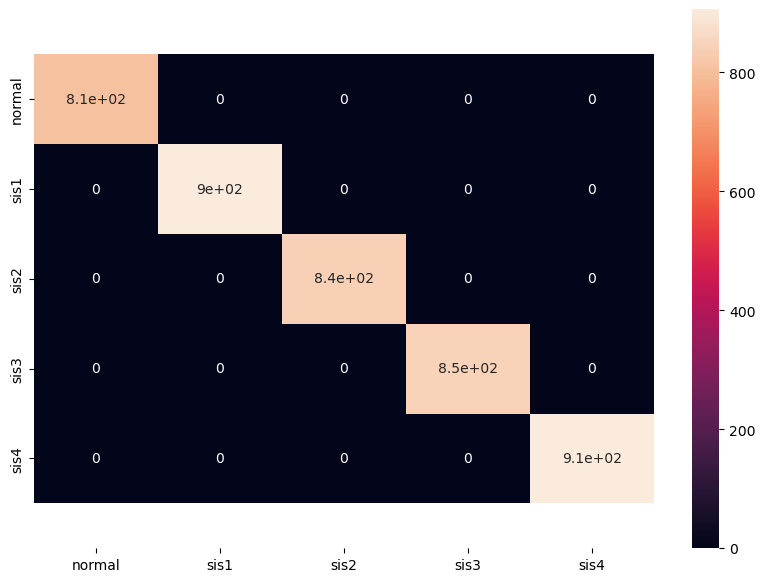

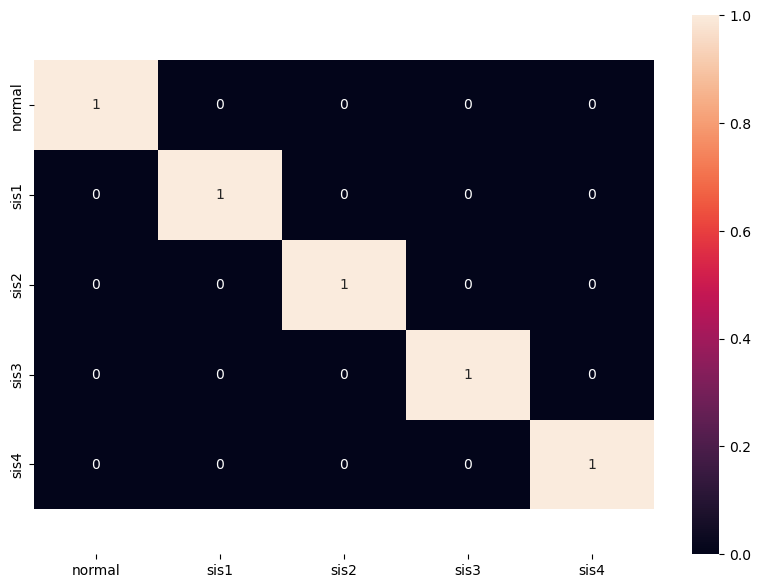

In [109]:
predict=[]
for i in range(len(predicted)):
    predict.append(predicted[i][0].detach().cpu())
predict
predd=[]
for i in range(len(predict)):
    predd.append(torch.argmax(predict[i]))
confusionmatrix(predd, real)


In [118]:
tracc=[]
vlacc=[]
feature_extractor = Extractor().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.0001)

for epoch in range(20):
    train_loss_num=0
    train_acc_num=0
    feature_extractor.train()
    for  X_train_batch, y_train_batch in train_ia_dataloader0:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        _,_,y_train_pred=feature_extractor(X_train_batch)
        train_loss=criterion(y_train_pred, y_train_batch)
        train_acc=multi_acc(y_train_pred,y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_loss_num += train_loss.item()
        train_acc_num  += train_acc.item()

    with torch.no_grad():
        val_loss_num = 0
        val_acc_num = 0

        feature_extractor.eval()
        for X_val_batch, y_val_batch in valid_ia_dataloader0:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            _,_,y_val_pred = feature_extractor(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_loss_num += val_loss.item()
            val_acc_num += val_acc.item()

    tracc.append(train_acc_num/len(train_ia_dataloader0))
    vlacc.append(val_acc_num/len(valid_ia_dataloader0))



    print(f'Epoch {epoch+0:03}: | Train Loss: {train_loss_num/len(train_ia_dataloader0):.5f} | Val Loss: {val_loss_num/len(valid_ia_dataloader0):.5f} | Train Acc: {train_acc_num/len(train_ia_dataloader0):.3f}| Val Acc: {val_acc_num/len(valid_ia_dataloader0):.3f}') 


Epoch 000: | Train Loss: 1.11002 | Val Loss: 0.83104 | Train Acc: 60.143| Val Acc: 74.373
Epoch 001: | Train Loss: 0.73483 | Val Loss: 0.72332 | Train Acc: 82.579| Val Acc: 83.992
Epoch 002: | Train Loss: 0.64218 | Val Loss: 0.60344 | Train Acc: 86.975| Val Acc: 90.567
Epoch 003: | Train Loss: 0.56023 | Val Loss: 0.69254 | Train Acc: 90.485| Val Acc: 83.132
Epoch 004: | Train Loss: 0.51460 | Val Loss: 0.52944 | Train Acc: 91.659| Val Acc: 90.753
Epoch 005: | Train Loss: 0.45928 | Val Loss: 0.51625 | Train Acc: 93.582| Val Acc: 88.569
Epoch 006: | Train Loss: 0.42330 | Val Loss: 0.38858 | Train Acc: 94.466| Val Acc: 94.354
Epoch 007: | Train Loss: 0.39361 | Val Loss: 0.40680 | Train Acc: 95.219| Val Acc: 92.356
Epoch 008: | Train Loss: 0.37674 | Val Loss: 0.42267 | Train Acc: 94.961| Val Acc: 93.843
Epoch 009: | Train Loss: 0.34618 | Val Loss: 0.31836 | Train Acc: 95.674| Val Acc: 96.515
Epoch 010: | Train Loss: 0.32218 | Val Loss: 0.30803 | Train Acc: 96.156| Val Acc: 95.330
Epoch 011:

In [119]:
tsacc=[]
predicted, real=[],[]
with torch.no_grad():
    tst_loss_num = 0
    tst_acc_num = 0
    
    feature_extractor.eval()
    for X_tst_batch, y_tst_batch in test_ia_dataloader0:
        X_tst_batch, y_tst_batch = X_tst_batch.to(device), y_tst_batch.to(device)

        _,_,y_tst_pred = feature_extractor(X_tst_batch)

        tst_acc = multi_acc(y_tst_pred, y_tst_batch)
        predicted.append(y_tst_pred)
        real.append(y_tst_batch)

        tst_acc_num += tst_acc.item()
    tsacc.append(tst_acc_num/len(test_ia_dataloader0))
print("test acc: ",tst_acc_num/len(test_ia_dataloader0))

test acc:  88.68494423791822


C:\Users\SHRM_DL\AppData\Local\Temp\ipykernel_9076\2165108675.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_cm =df_cm / df_cm.astype(np.float).sum(axis=1)


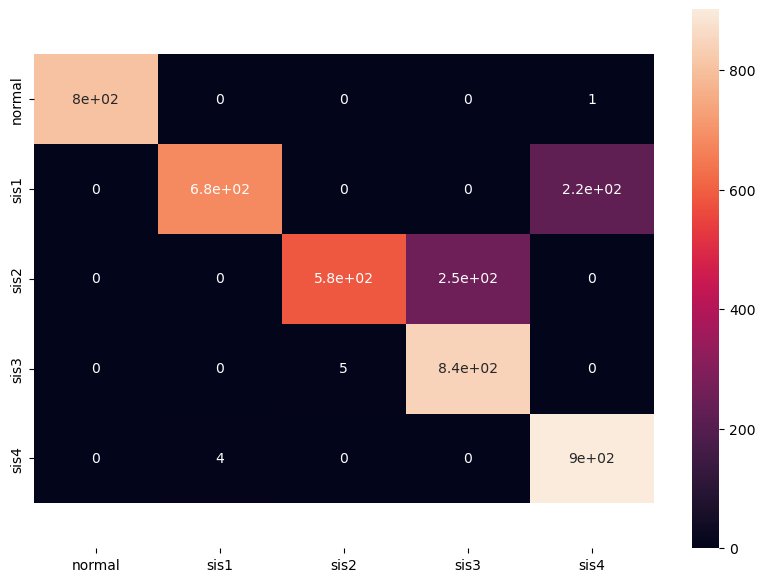

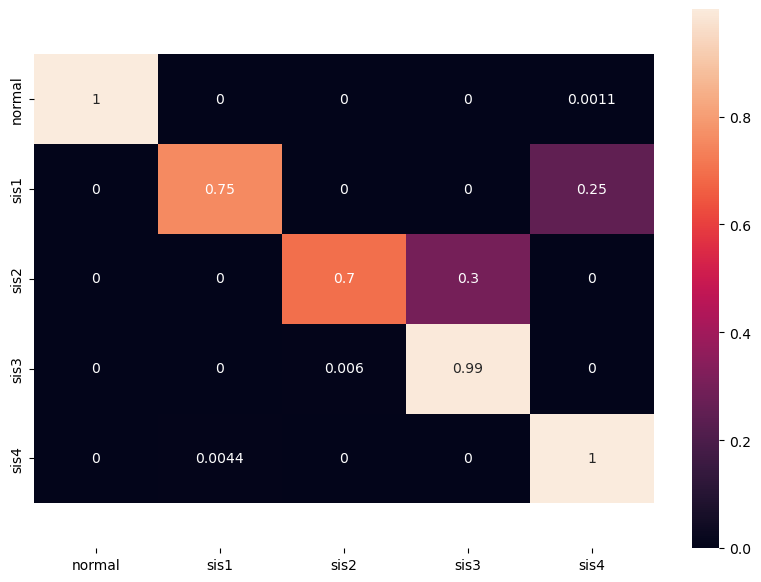

In [120]:
predict=[]
for i in range(len(predicted)):
    predict.append(predicted[i][0].detach().cpu())
predict
predd=[]
for i in range(len(predict)):
    predd.append(torch.argmax(predict[i]))
confusionmatrix(predd, real)


In [111]:
def tsneplot(loader1):
    TSNEmodel = TSNE(learning_rate=100)

    xsource=[]
    ysource=[]
    # xtarget=[]
    # ytarget=[]
    for batch_idx, batch_data2 in enumerate(loader1):
            tinput, tlabel = batch_data2
            xsource.append(np.array(tinput.detach().cpu()))
            ysource.append(tlabel.item())
    # for batch_idx, batch_data2 in enumerate(loader2):
    #         tinput, tlabel = batch_data2
    #         xtarget.append(np.array(tinput.detach().cpu()))
    #         ytarget.append(tlabel.item())

    xsource=np.array(xsource)
    ysource=np.array(ysource)
    # xtarget=np.array(xtarget)
    # ytarget=np.array(ytarget)
    
    # for i in range(len(ytarget)):
    #     if ytarget[i]==0:
    #         ytarget[i]=5
    #     elif ytarget[i]==1:
    #         ytarget[i]=6
    #     elif ytarget[i]==2:
    #         ytarget[i]=7
    #     elif ytarget[i]==3:
    #         ytarget[i]=8
    #     else:
    #         ytarget[i]=9 
        
    xsource=xsource.reshape(ysource.size,-1)
    # xtarget=xtarget.reshape(ytarget.size,-1)
    ysource=ysource.reshape(-1,1)
    # ytarget=ytarget.reshape(-1,1)
    
    source=np.hstack([xsource,ysource])
    # target=np.hstack([xtarget,ytarget])
    # tsne=np.vstack([source,target])
    tsne2=source[source[:,-1].argsort()]

    source_normal=np.where(tsne2[:,-1] == 0)[0][0]
    source_sis1=np.where(tsne2[:,-1] == 1)[0][0]
    source_sis2=np.where(tsne2[:,-1] == 2)[0][0]
    source_sis3=np.where(tsne2[:,-1] == 3)[0][0]
    source_sis4=np.where(tsne2[:,-1] == 4)[0][0]
    
    # target_normal=np.where(tsne2[:,-1] == 5)[0][0]
    # target_sis1=np.where(tsne2[:,-1] == 6)[0][0]
    # target_sis2=np.where(tsne2[:,-1] == 7)[0][0]
    # target_sis3=np.where(tsne2[:,-1] == 8)[0][0]
    # target_sis4=np.where(tsne2[:,-1] == 9)[0][0]
    tsne_X = TSNEmodel.fit_transform(tsne2[:,:-1],tsne2[:,-1])

    plt.figure(figsize=(10,10))
    
    plt.scatter(tsne_X[:source_sis1,0],tsne_X[:source_sis1,1],c='red',marker='o', label = 'source normal')
    plt.scatter(tsne_X[source_sis1:source_sis2,0],tsne_X[source_sis1:source_sis2,1],c='blue',marker='o', label = 'source sis1')
    plt.scatter(tsne_X[source_sis2:source_sis3,0],tsne_X[source_sis2:source_sis3,1],c='yellow',marker='o', label = 'source sis2')
    plt.scatter(tsne_X[source_sis3:source_sis4,0],tsne_X[source_sis3:source_sis4,1],c='black',marker='o', label = 'source sis3')
    plt.scatter(tsne_X[source_sis4:,0],tsne_X[source_sis4:,1],c='purple',marker='o' ,label = 'source sis4')
    # plt.scatter(tsne_X[target_normal:target_sis1,0],tsne_X[target_normal:target_sis1,1],c='red',marker='s', label = 'target normal')
    # plt.scatter(tsne_X[target_sis1:target_sis2,0],tsne_X[target_sis1:target_sis2,1],c='blue',marker='s', label = 'target sis1')
    # plt.scatter(tsne_X[target_sis2:target_sis3,0],tsne_X[target_sis2:target_sis3,1],c='yellow',marker='s', label = 'target sis2')
    # plt.scatter(tsne_X[target_sis3:target_sis4,0],tsne_X[target_sis3:target_sis4,1],c='black',marker='s', label = 'target sis3')
    # plt.scatter(tsne_X[target_sis4:,0],tsne_X[target_sis4:,1],c='purple',marker='s', label = 'target sis4')

    plt.suptitle('tsne test')
    # plt.legend()

    plt.show()

In [114]:
def tsneplotafter(loader1):
    TSNEmodel = TSNE(learning_rate=100)

    xsource=[]
    ysource=[]
    # xtarget=[]
    # ytarget=[]
    for batch_idx, batch_data2 in enumerate(loader1):
            tinput, tlabel = batch_data2
            tinput = Variable(tinput.cuda())
            _,tinput,_  = feature_extractor(tinput)
            xsource.append(np.array(tinput.detach().cpu()))
            ysource.append(tlabel.item())
    # for batch_idx, batch_data2 in enumerate(loader2):
    #         tinput, tlabel = batch_data2
    #         tinput = Variable(tinput.cuda())
    #         tinput = feature_extractor(tinput)
    #         xtarget.append(np.array(tinput.detach().cpu()))
    #         ytarget.append(tlabel.item())

    xsource=np.array(xsource)
    ysource=np.array(ysource)
    # xtarget=np.array(xtarget)
    # ytarget=np.array(ytarget)

#     for i in range(len(ytarget)):
#         if ytarget[i]==0:
#             ytarget[i]=5
#         elif ytarget[i]==1:
#             ytarget[i]=6
#         elif ytarget[i]==2:
#             ytarget[i]=7
#         elif ytarget[i]==3:
#             ytarget[i]=8
#         else:
#             ytarget[i]=9 
            
    xsource=xsource.reshape(ysource.size,-1)
    # xtarget=xtarget.reshape(ytarget.size,-1)
    ysource=ysource.reshape(-1,1)
    # ytarget=ytarget.reshape(-1,1)
    
    source=np.hstack([xsource,ysource])
    # target=np.hstack([xtarget,ytarget])
    # tsne=np.vstack([source,target])
    tsne2=source[source[:,-1].argsort()]

    source_normal=np.where(tsne2[:,-1] == 0)[0][0]
    source_sis1=np.where(tsne2[:,-1] == 1)[0][0]
    source_sis2=np.where(tsne2[:,-1] == 2)[0][0]
    source_sis3=np.where(tsne2[:,-1] == 3)[0][0]
    source_sis4=np.where(tsne2[:,-1] == 4)[0][0]
    
    # target_normal=np.where(tsne2[:,-1] == 5)[0][0]
    # target_sis1=np.where(tsne2[:,-1] == 6)[0][0]
    # target_sis2=np.where(tsne2[:,-1] == 7)[0][0]
    # target_sis3=np.where(tsne2[:,-1] == 8)[0][0]
    # target_sis4=np.where(tsne2[:,-1] == 9)[0][0]
    tsne_X = TSNEmodel.fit_transform(tsne2[:,:-1],tsne2[:,-1])

    plt.figure(figsize=(10,10))
    
    plt.scatter(tsne_X[:source_sis1,0],tsne_X[:source_sis1,1],c='red',marker='o', label = 'source normal')
    plt.scatter(tsne_X[source_sis1:source_sis2,0],tsne_X[source_sis1:source_sis2,1],c='blue',marker='o', label = 'source sis1')
    plt.scatter(tsne_X[source_sis2:source_sis3,0],tsne_X[source_sis2:source_sis3,1],c='yellow',marker='o', label = 'source sis2')
    plt.scatter(tsne_X[source_sis3:source_sis4,0],tsne_X[source_sis3:source_sis4,1],c='black',marker='o', label = 'source sis3')
    plt.scatter(tsne_X[source_sis4:,0],tsne_X[source_sis4:,1],c='purple',marker='o' ,label = 'source sis4')
    
#     plt.scatter(tsne_X[target_normal:target_sis1,0],tsne_X[target_normal:target_sis1,1],c='red',marker='s', label = 'target normal')
#     plt.scatter(tsne_X[target_sis1:target_sis2,0],tsne_X[target_sis1:target_sis2,1],c='blue',marker='s', label = 'target sis1')
#     plt.scatter(tsne_X[target_sis2:target_sis3,0],tsne_X[target_sis2:target_sis3,1],c='yellow',marker='s', label = 'target sis2')
#     plt.scatter(tsne_X[target_sis3:target_sis4,0],tsne_X[target_sis3:target_sis4,1],c='black',marker='s', label = 'target sis3')
#     plt.scatter(tsne_X[target_sis4:,0],tsne_X[target_sis4:,1],c='purple',marker='s', label = 'target sis4')

    plt.suptitle('tsne after')
    # plt.legend()

    plt.show()

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


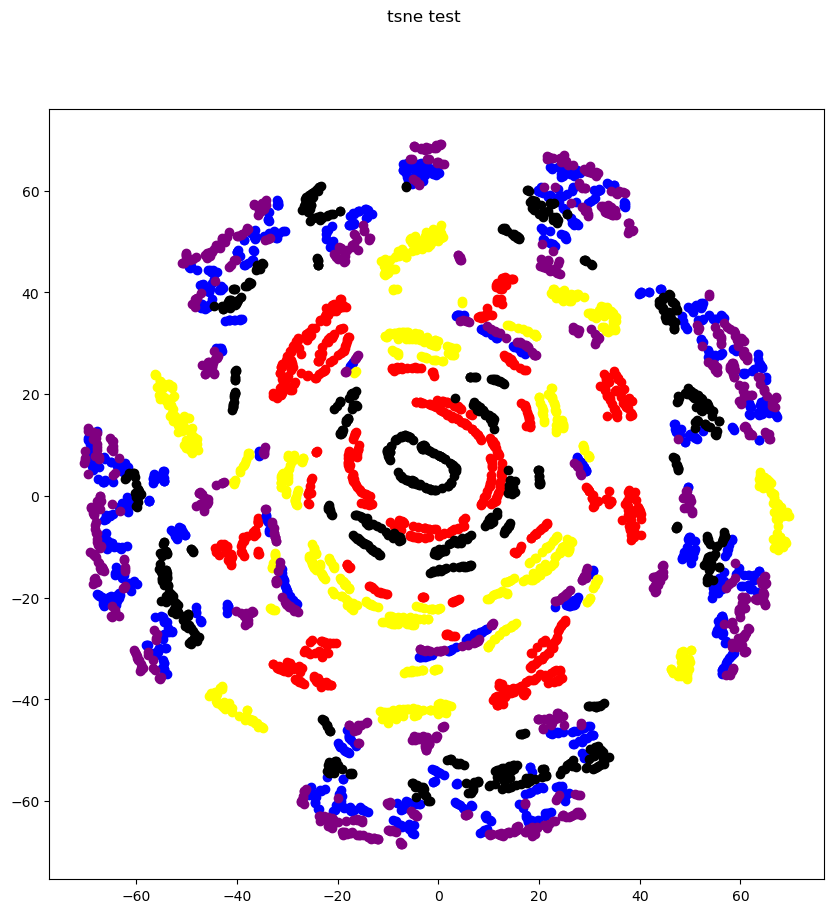

In [113]:
tsneplot(test_v1_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


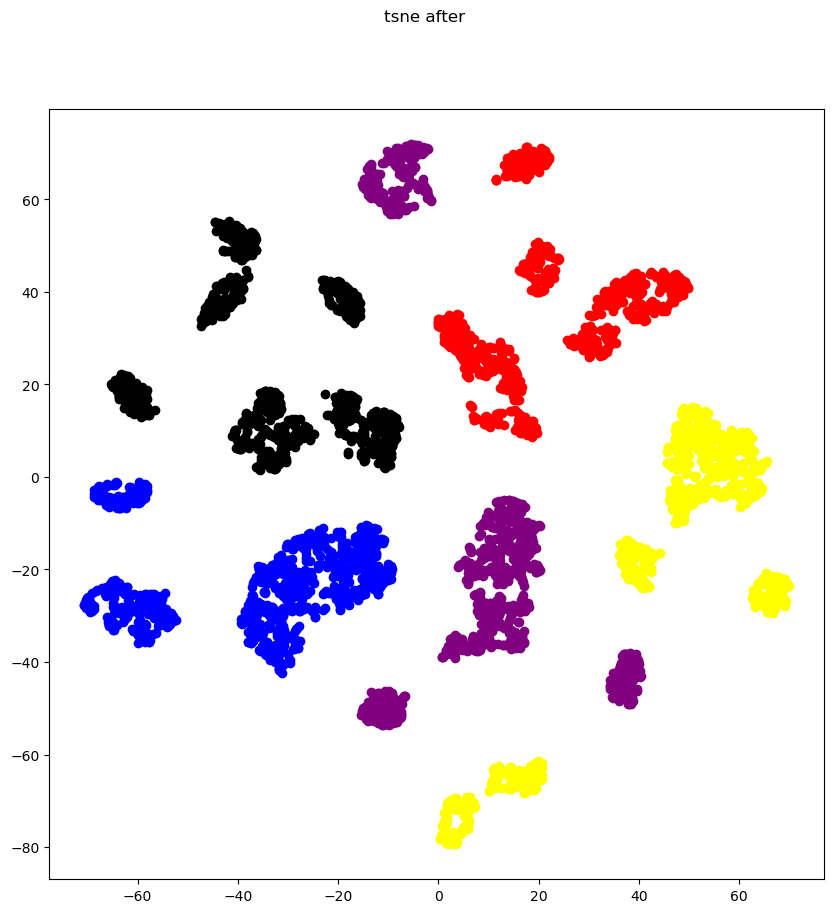

In [115]:
tsneplotafter(test_v1_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


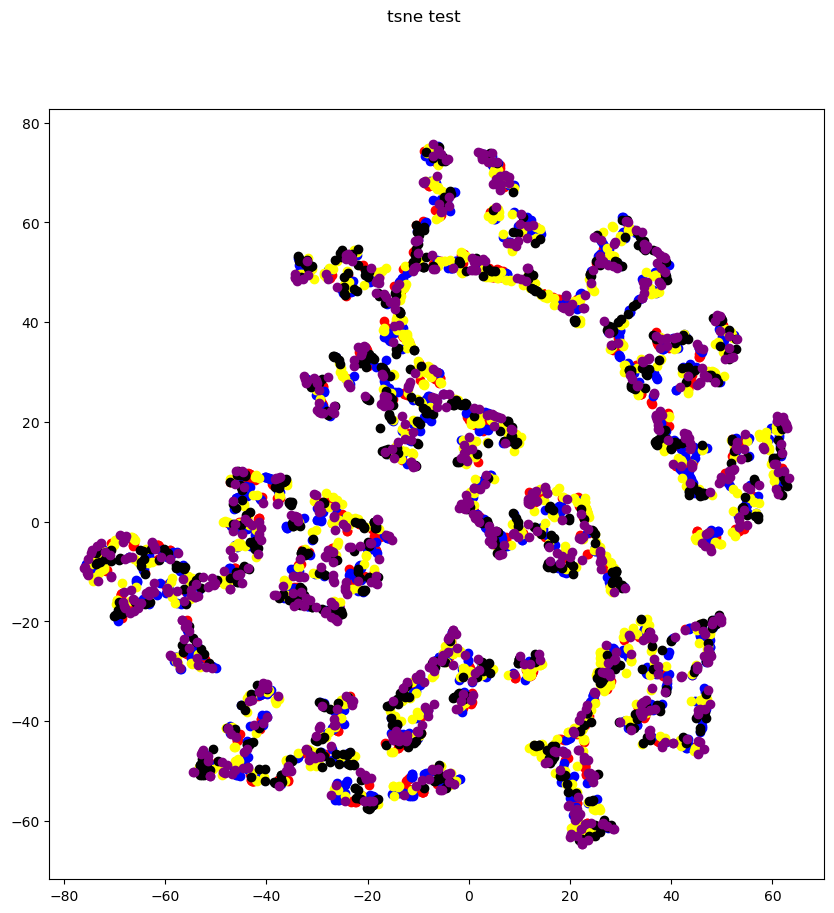

In [116]:
tsneplot(test_ia_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


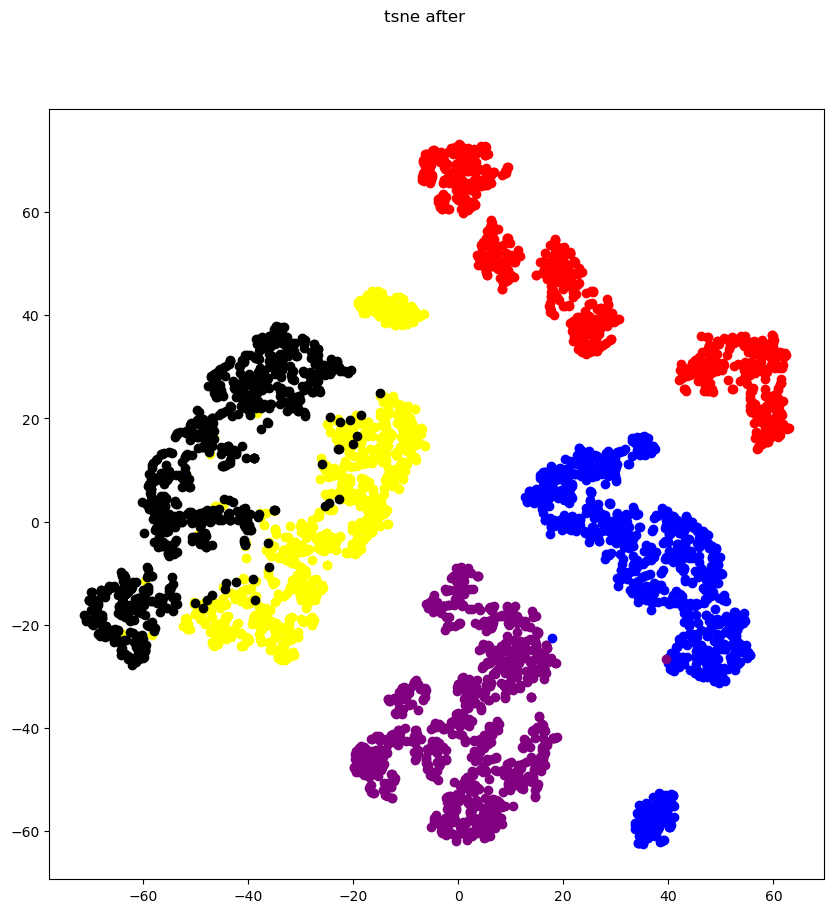

In [122]:
tsneplotafter(test_ia_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


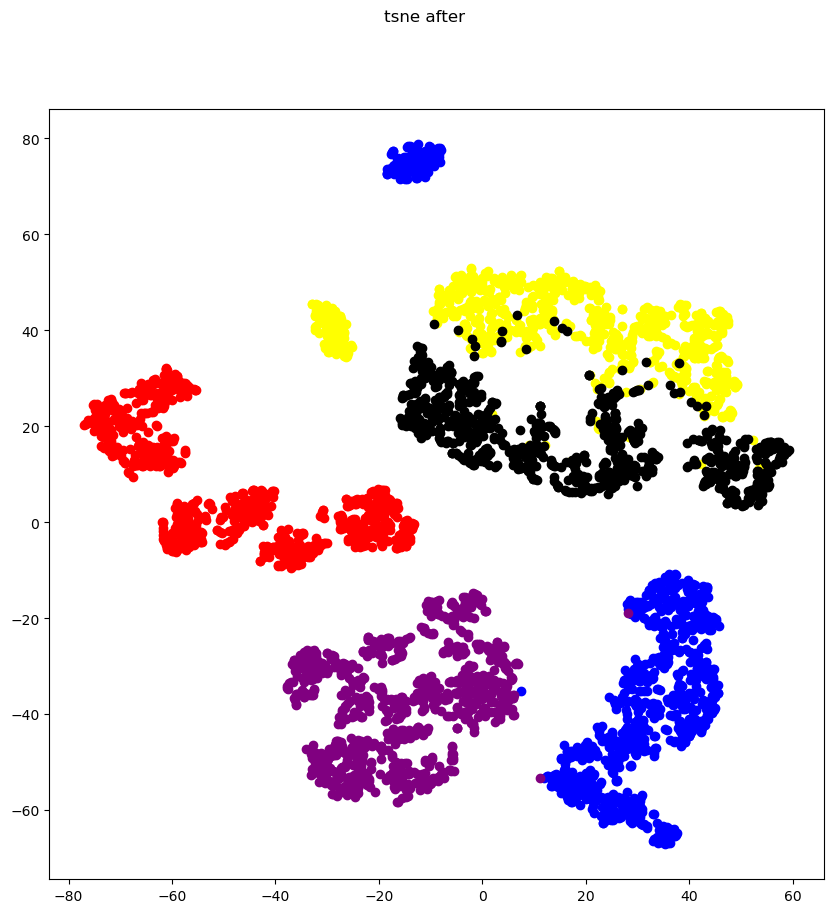

In [125]:
tsneplotafter(test_ia_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


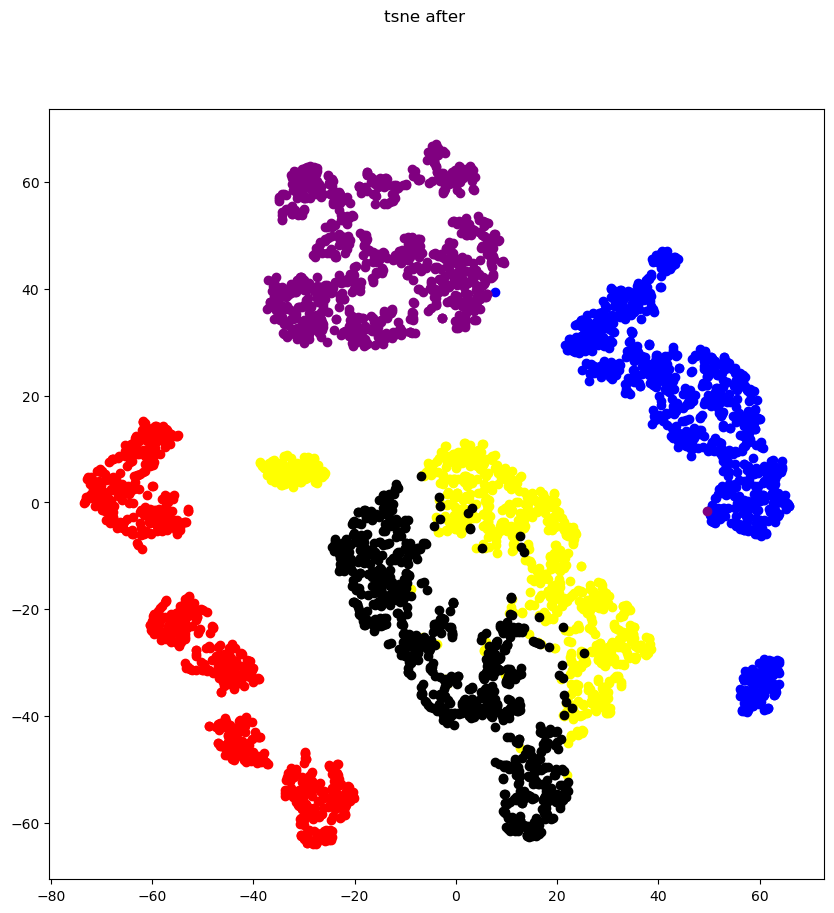

In [126]:
tsneplotafter(test_ia_dataloader0)

C:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


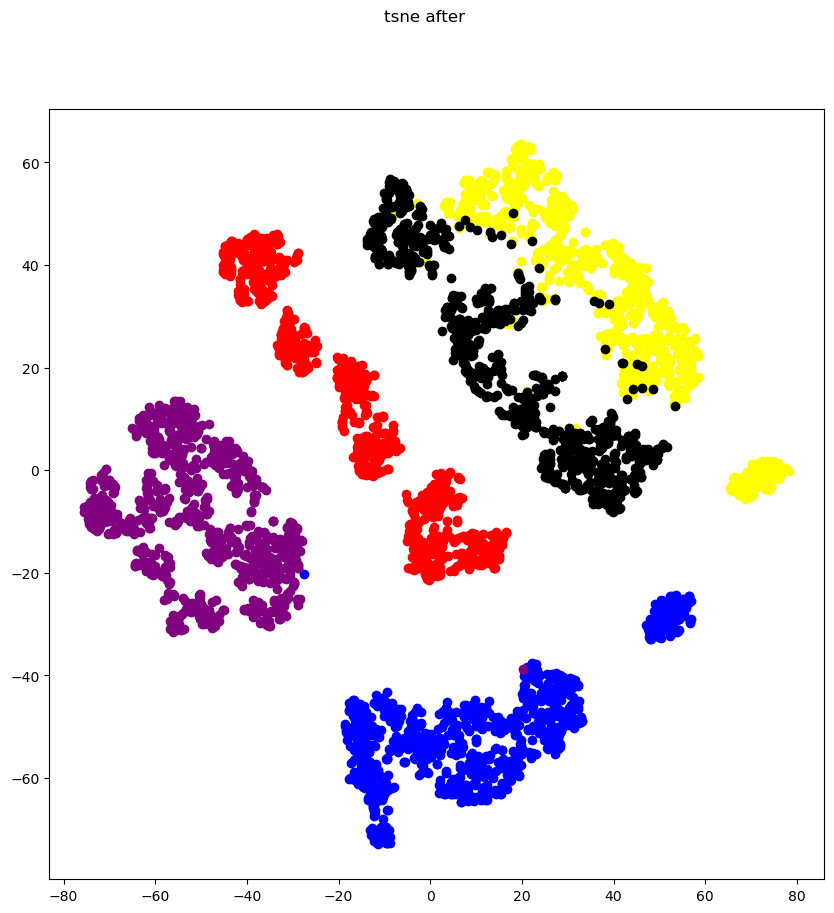

In [127]:
tsneplotafter(test_ia_dataloader0)

In [ ]:
tsneplotafter(test_ia_dataloader0)

In [ ]:
tsneplotafter(test_ia_dataloader0)